In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Glass_Quality_Participants_Data/Test.csv
/kaggle/input/Glass_Quality_Participants_Data/Sample_Submission.xlsx
/kaggle/input/Glass_Quality_Participants_Data/Train.csv


In [2]:
train = pd.read_csv('/kaggle/input/Glass_Quality_Participants_Data/Train.csv')
test = pd.read_csv('/kaggle/input/Glass_Quality_Participants_Data/Test.csv')
sub = pd.read_excel('/kaggle/input/Glass_Quality_Participants_Data/Sample_Submission.xlsx')

In [3]:
train.shape, test.shape, sub.shape

((1358, 16), (583, 15), (583, 2))

In [4]:
train.head(3)

,grade_A_Component_1,grade_A_Component_2,max_luminosity,thickness,xmin,xmax,ymin,ymax,pixel_area,log_area,x_component_1,x_component_2,x_component_3,x_component_4,x_component_5,class
0,0,1,150,36,144,172,947225,947332,439,439.099273,0,0,1,0,0,1
1,1,0,134,55,1144,1152,2379058,2379624,329,329.205616,1,0,0,0,0,1
2,1,0,135,65,950,974,1038442,1036754,300,300.120598,0,0,0,0,0,2


In [5]:
train['class'].value_counts()

1    887
2    471
Name: class, dtype: int64

In [6]:
train.nunique()

grade_A_Component_1       2
grade_A_Component_2       2
max_luminosity          131
thickness               143
xmin                    775
xmax                    811
ymin                   1358
ymax                   1358
pixel_area              813
log_area               1358
x_component_1             2
x_component_2             2
x_component_3             2
x_component_4             2
x_component_5             2
class                     2
dtype: int64

In [7]:
X = train.drop(labels=['class'], axis=1)
y = train['class'].values

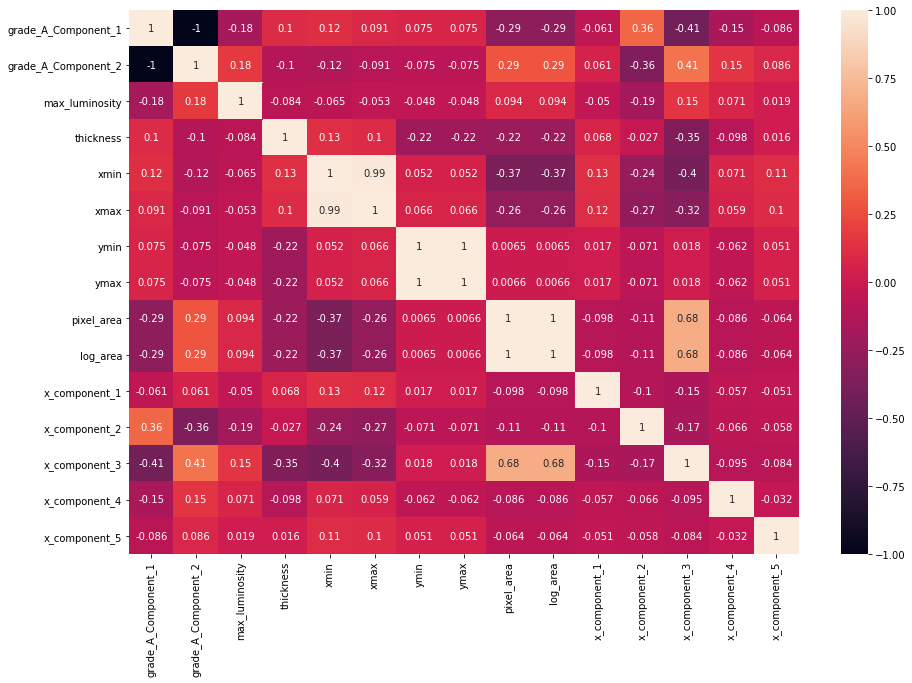

In [8]:
corr = X.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, annot=True)
plt.show()

In [9]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.7" 2020-04-14; OpenJDK Runtime Environment (build 11.0.7+10-post-Ubuntu-2ubuntu218.04); OpenJDK 64-Bit Server VM (build 11.0.7+10-post-Ubuntu-2ubuntu218.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgqc1axni
  JVM stdout: /tmp/tmpgqc1axni/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgqc1axni/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_unknownUser_vogu3j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.250 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [10]:
from h2o.automl import H2OAutoML

In [20]:
df = h2o.import_file('/kaggle/input/Glass_Quality_Participants_Data/Train.csv')
testing_df = h2o.import_file('/kaggle/input/Glass_Quality_Participants_Data/Test.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
df['class'] = df['class'].asfactor()

In [13]:
df['class'].table()

class,Count
1,887
2,471


In [14]:
train, test, valid = df.split_frame(ratios=[.85,0.10], seed=11)

In [15]:
y = "class"
x = df.columns
x.remove(y)

In [16]:
aml = H2OAutoML(nfolds=10,
    balance_classes=True,
    class_sampling_factors=None,
    max_after_balance_size=5.0,
    max_runtime_secs=None,
    max_runtime_secs_per_model=None,
    max_models=None,
    stopping_metric='AUTO',
    stopping_tolerance=None,
    stopping_rounds=None,
    seed=4,
    project_name=None,
    exclude_algos=['DeepLearning'],
    include_algos=None,
    exploitation_ratio=0,
    modeling_plan=None,
    monotone_constraints=None,
    algo_parameters=None,
    keep_cross_validation_predictions=True,
    keep_cross_validation_models=False,
    keep_cross_validation_fold_assignment=True,
    sort_metric='logloss',
    export_checkpoints_dir=None,
    verbosity='warn',
)

In [17]:
aml.train(x = x, y = y, training_frame = train, validation_frame=valid)

AutoML progress: |
05:02:07.945: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


In [18]:
lb = aml.leaderboard
lb

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
GBM_3_AutoML_20200524_050207,0.288589,0.9417,0.870333,0.120473,0.305129,0.0931034
XGBoost_grid__1_AutoML_20200524_050207_model_6,0.290119,0.941971,0.865298,0.122253,0.303566,0.0921521
StackedEnsemble_BestOfFamily_AutoML_20200524_050207,0.290473,0.943834,0.879685,0.117124,0.302833,0.091708
GBM_4_AutoML_20200524_050207,0.29066,0.941795,0.869561,0.12051,0.306697,0.0940632
StackedEnsemble_AllModels_AutoML_20200524_050207,0.292373,0.943346,0.878812,0.127381,0.304489,0.0927135
XGBoost_grid__1_AutoML_20200524_050207_model_22,0.293941,0.940442,0.866934,0.117754,0.304749,0.0928718
GBM_grid__1_AutoML_20200524_050207_model_4,0.294397,0.940347,0.866667,0.126301,0.309039,0.0955053
GBM_2_AutoML_20200524_050207,0.294626,0.939022,0.866646,0.125745,0.309335,0.095688
GBM_grid__1_AutoML_20200524_050207_model_3,0.294658,0.939214,0.871208,0.130837,0.308212,0.0949946
GBM_1_AutoML_20200524_050207,0.296109,0.938382,0.873629,0.133489,0.310019,0.0961119


In [33]:
pred_df = aml.leader.predict(testing_df)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [22]:
aml.leader.confusion_matrix

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_3_AutoML_20200524_050207


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,59.0,59.0,32682.0,8.0,8.0,8.0,17.0,63.0,39.23729




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.03546731281093275
RMSE: 0.1883276740442911
LogLoss: 0.15244209169389675
Mean Per-Class Error: 0.01928928069901703
AUC: 0.9981418176144343
AUCPR: 0.9981580144696721
Gini: 0.9962836352288686

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4235444264855932: 


,,1,2,Error,Rate
0,1,736.0,18.0,0.0239,(18.0/754.0)
1,2,11.0,737.0,0.0147,(11.0/748.0)
2,Total,747.0,755.0,0.0193,(29.0/1502.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.423544,0.980705,224.0
1,max f2,0.402136,0.986422,229.0
2,max f0point5,0.511211,0.984561,214.0
3,max accuracy,0.464519,0.980692,218.0
4,max precision,0.979946,1.000000,0.0
5,max recall,0.248911,1.000000,273.0
6,max specificity,0.979946,1.000000,0.0
7,max absolute_mcc,0.423544,0.961427,224.0
8,max min_per_class_accuracy,0.461405,0.979947,220.0
9,max mean_per_class_accuracy,0.423544,0.980711,224.0



Gains/Lift Table: Avg response rate: 49.80 %, avg score: 44.31 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010652,0.970954,2.008021,2.008021,1.00,0.975066,1.000000,0.975066,0.021390,0.021390,100.802139,100.802139
1,,2,0.020639,0.966497,2.008021,2.008021,1.00,0.967657,1.000000,0.971481,0.020053,0.041444,100.802139,100.802139
2,,3,0.031292,0.962111,2.008021,2.008021,1.00,0.963476,1.000000,0.968756,0.021390,0.062834,100.802139,100.802139
3,,4,0.040613,0.959563,2.008021,2.008021,1.00,0.960958,1.000000,0.966966,0.018717,0.081551,100.802139,100.802139
4,,5,0.050599,0.953888,2.008021,2.008021,1.00,0.956248,1.000000,0.964851,0.020053,0.101604,100.802139,100.802139
5,,6,0.101198,0.934049,2.008021,2.008021,1.00,0.941836,1.000000,0.953344,0.101604,0.203209,100.802139,100.802139
6,,7,0.151132,0.903060,2.008021,2.008021,1.00,0.916692,1.000000,0.941234,0.100267,0.303476,100.802139,100.802139
7,,8,0.201065,0.876235,2.008021,2.008021,1.00,0.888647,1.000000,0.928174,0.100267,0.403743,100.802139,100.802139
8,,9,0.300266,0.806990,2.008021,2.008021,1.00,0.844408,1.000000,0.900500,0.199198,0.602941,100.802139,100.802139
9,,10,0.400133,0.729320,2.008021,2.008021,1.00,0.765599,1.000000,0.866831,0.200535,0.803476,100.802139,100.802139




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.10096061304069288
RMSE: 0.31774299841332915
LogLoss: 0.3019146565345054
Mean Per-Class Error: 0.12908496732026142
AUC: 0.934640522875817
AUCPR: 0.8837638086958837
Gini: 0.869281045751634

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3561046517977821: 


,,1,2,Error,Rate
0,1,29.0,5.0,0.1471,(5.0/34.0)
1,2,2.0,16.0,0.1111,(2.0/18.0)
2,Total,31.0,21.0,0.1346,(7.0/52.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.356105,0.820513,20.0
1,max f2,0.151649,0.909091,26.0
2,max f0point5,0.760976,0.833333,11.0
3,max accuracy,0.418384,0.865385,18.0
4,max precision,0.952312,1.000000,0.0
5,max recall,0.151649,1.000000,26.0
6,max specificity,0.952312,1.000000,0.0
7,max absolute_mcc,0.356105,0.719266,20.0
8,max min_per_class_accuracy,0.356105,0.852941,20.0
9,max mean_per_class_accuracy,0.356105,0.870915,20.0



Gains/Lift Table: Avg response rate: 34.62 %, avg score: 32.30 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.019231,0.946006,2.888889,2.888889,1.000000,0.952312,1.000000,0.952312,0.055556,0.055556,188.888889,188.888889
1,,2,0.038462,0.939814,2.888889,2.888889,1.000000,0.939948,1.000000,0.946130,0.055556,0.111111,188.888889,188.888889
2,,3,0.038462,0.936404,0.000000,2.888889,0.000000,0.000000,1.000000,0.946130,0.000000,0.111111,-100.000000,188.888889
3,,4,0.057692,0.931230,2.888889,2.888889,1.000000,0.933261,1.000000,0.941840,0.055556,0.166667,188.888889,188.888889
4,,5,0.057692,0.905335,0.000000,2.888889,0.000000,0.000000,1.000000,0.941840,0.000000,0.166667,-100.000000,188.888889
5,,6,0.115385,0.822280,2.888889,2.888889,1.000000,0.849801,1.000000,0.895821,0.166667,0.333333,188.888889,188.888889
6,,7,0.153846,0.787251,2.888889,2.888889,1.000000,0.805477,1.000000,0.873235,0.111111,0.444444,188.888889,188.888889
7,,8,0.211538,0.775431,1.925926,2.626263,0.666667,0.783071,0.909091,0.848645,0.111111,0.555556,92.592593,162.626263
8,,9,0.307692,0.562109,1.155556,2.166667,0.400000,0.655375,0.750000,0.788248,0.111111,0.666667,15.555556,116.666667
9,,10,0.403846,0.351919,2.311111,2.201058,0.800000,0.438717,0.761905,0.705026,0.222222,0.888889,131.111111,120.105820




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.09310340370301279
RMSE: 0.3051285035899019
LogLoss: 0.2885889783592331
Mean Per-Class Error: 0.12036975327566213
AUC: 0.9416995454727217
AUCPR: 0.870333114028615
Gini: 0.8833990909454434

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32735007069050653: 


,,1,2,Error,Rate
0,1,650.0,104.0,0.1379,(104.0/754.0)
1,2,41.0,357.0,0.103,(41.0/398.0)
2,Total,691.0,461.0,0.1259,(145.0/1152.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.327350,0.831199,249.0
1,max f2,0.154763,0.905713,304.0
2,max f0point5,0.423594,0.811132,224.0
3,max accuracy,0.408785,0.877604,229.0
4,max precision,0.984179,1.000000,0.0
5,max recall,0.018720,1.000000,366.0
6,max specificity,0.984179,1.000000,0.0
7,max absolute_mcc,0.327350,0.736733,249.0
8,max min_per_class_accuracy,0.377001,0.874005,237.0
9,max mean_per_class_accuracy,0.283222,0.879630,262.0



Gains/Lift Table: Avg response rate: 34.55 %, avg score: 32.16 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010417,0.970821,2.653266,2.653266,0.916667,0.975763,0.916667,0.975763,0.027638,0.027638,165.326633,165.326633
1,,2,0.020833,0.958247,2.894472,2.773869,1.000000,0.963402,0.958333,0.969583,0.030151,0.057789,189.447236,177.386935
2,,3,0.030382,0.951603,2.894472,2.811773,1.000000,0.954587,0.971429,0.964870,0.027638,0.085427,189.447236,181.177315
3,,4,0.040799,0.945614,2.653266,2.771303,0.916667,0.949339,0.957447,0.960905,0.027638,0.113065,165.326633,177.130333
4,,5,0.050347,0.930447,2.894472,2.794663,1.000000,0.938994,0.965517,0.956749,0.027638,0.140704,189.447236,179.466297
5,,6,0.100694,0.880866,2.545139,2.669901,0.879310,0.904032,0.922414,0.930390,0.128141,0.268844,154.513949,166.990123
6,,7,0.150174,0.821616,2.539011,2.626775,0.877193,0.850045,0.907514,0.903918,0.125628,0.394472,153.901084,162.677550
7,,8,0.200521,0.764937,2.395425,2.568688,0.827586,0.791213,0.887446,0.875620,0.120603,0.515075,139.542540,156.868759
8,,9,0.300347,0.581651,2.089054,2.409272,0.721739,0.677500,0.832370,0.809771,0.208543,0.723618,108.905397,140.927179
9,,10,0.400174,0.325377,1.736683,2.241489,0.600000,0.472750,0.774403,0.725699,0.173367,0.896985,73.668342,124.148944




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.8906522,0.027616927,0.8362069,0.9137931,0.8695652,0.8956522,0.9217391,0.87826085,0.9217391,0.9130435,0.87826085,0.87826085
1,auc,0.9409312,0.015275413,0.92424244,0.95592105,0.93863046,0.941,0.9633333,0.921895,0.9556962,0.9502205,0.9377637,0.9206095
2,aucpr,0.867287,0.06325742,0.8797558,0.9253491,0.8988186,0.83247936,0.9321436,0.83144385,0.88141865,0.91286975,0.8612226,0.71736825
3,err,0.10934783,0.027616927,0.1637931,0.0862069,0.13043478,0.104347825,0.07826087,0.12173913,0.07826087,0.08695652,0.12173913,0.12173913
4,err_count,12.6,3.204164,19.0,10.0,15.0,12.0,9.0,14.0,9.0,10.0,14.0,14.0
5,f0point5,0.81908613,0.052530188,0.75,0.86538464,0.7818182,0.8189655,0.8726415,0.8196721,0.8695652,0.88235295,0.7908163,0.73964494
6,f1,0.8518703,0.037072927,0.815534,0.8780488,0.85148513,0.8636364,0.8915663,0.85106385,0.8767123,0.89361703,0.81578946,0.78125
7,f2,0.8888592,0.032382574,0.89361703,0.8910891,0.9347826,0.91346157,0.91133004,0.88495576,0.8839779,0.9051724,0.8423913,0.8278146
8,lift_top_group,2.9428825,0.42869028,2.6363637,2.9,2.6744187,2.875,2.875,2.6136363,3.1944444,2.5,3.1944444,3.9655173
9,logloss,0.28856105,0.032469835,0.3312713,0.27802873,0.30830002,0.28170538,0.23038417,0.33495277,0.25155187,0.28399652,0.28390056,0.30151913



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-05-24 05:03:21,7.364 sec,0.0,0.522740,0.742056,0.500000,0.498003,1.000000,0.501997,0.475743,0.645034,0.500000,0.346154,1.000000,0.653846
1,,2020-05-24 05:03:21,7.422 sec,5.0,0.428166,0.541903,0.953498,0.947405,2.008021,0.117843,0.394193,0.482574,0.942810,0.891995,2.888889,0.153846
2,,2020-05-24 05:03:21,7.460 sec,10.0,0.369518,0.432396,0.965773,0.961245,2.008021,0.091212,0.353957,0.404747,0.939542,0.899282,2.888889,0.115385
3,,2020-05-24 05:03:21,7.499 sec,15.0,0.326864,0.356529,0.973663,0.970405,2.008021,0.083222,0.331201,0.357261,0.937908,0.891040,2.888889,0.134615
4,,2020-05-24 05:03:21,7.541 sec,20.0,0.301723,0.313080,0.978835,0.976605,2.008021,0.071238,0.318107,0.330247,0.946078,0.908826,2.888889,0.115385
5,,2020-05-24 05:03:21,7.590 sec,25.0,0.281472,0.278728,0.981795,0.980336,2.008021,0.071904,0.314041,0.316593,0.942810,0.904874,2.888889,0.115385
6,,2020-05-24 05:03:21,7.648 sec,30.0,0.260643,0.247809,0.987177,0.986402,2.008021,0.056591,0.317029,0.317323,0.934641,0.890080,2.888889,0.134615
7,,2020-05-24 05:03:21,7.691 sec,35.0,0.246733,0.226915,0.989834,0.989148,2.008021,0.052597,0.313955,0.308294,0.939542,0.887237,2.888889,0.134615
8,,2020-05-24 05:03:21,7.736 sec,40.0,0.233171,0.208127,0.992009,0.991465,2.008021,0.041944,0.310196,0.299781,0.942810,0.893513,2.888889,0.115385
9,,2020-05-24 05:03:21,7.780 sec,45.0,0.222523,0.193503,0.993974,0.993796,2.008021,0.036618,0.313659,0.303500,0.939542,0.884656,2.888889,0.115385



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,x_component_3,282.158356,1.000000,0.189124
1,thickness,203.763733,0.722161,0.136578
2,x_component_2,173.259064,0.614049,0.116131
3,x_component_1,154.688095,0.548231,0.103684
4,max_luminosity,89.618813,0.317619,0.060069
5,ymax,78.770531,0.279171,0.052798
6,x_component_4,77.321671,0.274036,0.051827
7,xmax,72.450768,0.256773,0.048562
8,ymin,68.280876,0.241995,0.045767
9,x_component_5,65.316605,0.231489,0.043780


<bound method H2OBinomialModel.confusion_matrix of >

In [24]:
pred_df

predict,p1,p2
1,0.990796,0.00920403
2,0.317884,0.682116
1,0.989301,0.0106994
1,0.985558,0.014442
1,0.922033,0.0779672
1,0.984307,0.0156928
1,0.995164,0.00483646
1,0.995684,0.00431608
1,0.966998,0.0330024
2,0.4917,0.5083


In [43]:
y_pred = pred_df.as_data_frame()
y_pred.drop(['predict'], axis=1, inplace=True)
y_pred = y_pred.rename(columns={'p1':1, 'p2':2})
y_pred.head(2)

,1,2
0,0.990796,0.009204
1,0.317884,0.682116


In [45]:
y_pred.to_excel('Output.xlsx', index=False)

In [44]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

def create_download_link(df, title = "Download CSV file", filename = "Output.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(y_pred)